In [1]:
import numpy as np
import gym
from collections import defaultdict
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
class BasicAgent:
    ALGO_NAME = '---'

    def __init__(self, env, eps=0.1):
        self.env = env
        self.nA = env.action_space.n
        # Используем defaultdict для удобства
        self.Q = defaultdict(lambda: np.zeros(self.nA))
        self.eps = eps
        self.episodes_reward = []

    def get_state(self, state):
        # В CartPole состояния могут быть непрерывными, здесь мы их дискретизируем
        # Например, округлим значения до определенной точности
        return tuple([round(s, 2) for s in state])

    def greedy(self, state):
        state = self.get_state(state)
        return np.argmax(self.Q[state])

    def make_action(self, state):
        state = self.get_state(state)
        if np.random.uniform(0, 1) < self.eps:
            return self.env.action_space.sample()
        else:
            return self.greedy(state)

    def draw_episodes_reward(self):
        fig, ax = plt.subplots(figsize=(15, 10))
        y = self.episodes_reward
        x = list(range(1, len(y) + 1))
        plt.plot(x, y, '-', linewidth=1, color='green')
        plt.title('Награды по эпизодам')
        plt.xlabel('Номер эпизода')
        plt.ylabel('Награда')
        plt.show()

    def learn(self):
        pass

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
class SarsaAgent(BasicAgent):
    ALGO_NAME = 'SARSA'

    def __init__(self, env, eps=0.1, lr=0.1, gamma=0.95, num_episodes=2000):
        super().__init__(env, eps)
        self.lr = lr
        self.gamma = gamma
        self.num_episodes = num_episodes

    def learn(self):
        for ep in tqdm(range(self.num_episodes)):
            state = self.env.reset()
            action = self.make_action(state)
            done = False
            total_reward = 0
            while not done:
                next_state, reward, done, _ = self.env.step(action)
                next_action = self.make_action(next_state)
                self.Q[self.get_state(state)][action] += self.lr * (
                    reward + self.gamma * self.Q[self.get_state(next_state)][next_action] - self.Q[self.get_state(state)][action]
                )
                state = next_state
                action = next_action
                total_reward += reward
            self.episodes_reward.append(total_reward)

In [4]:
class QLearningAgent(BasicAgent):
    ALGO_NAME = 'Q-learning'

    def __init__(self, env, eps=0.1, lr=0.1, gamma=0.95, num_episodes=2000):
        super().__init__(env, eps)
        self.lr = lr
        self.gamma = gamma
        self.num_episodes = num_episodes

    def learn(self):
        for ep in tqdm(range(self.num_episodes)):
            state = self.env.reset()
            done = False
            total_reward = 0
            while not done:
                action = self.make_action(state)
                next_state, reward, done, _ = self.env.step(action)
                self.Q[self.get_state(state)][action] += self.lr * (
                    reward + self.gamma * np.max(self.Q[self.get_state(next_state)]) - self.Q[self.get_state(state)][action]
                )
                state = next_state
                total_reward += reward
            self.episodes_reward.append(total_reward)

In [5]:
class DoubleQLearningAgent(BasicAgent):
    ALGO_NAME = 'Double Q-learning'

    def __init__(self, env, eps=0.1, lr=0.1, gamma=0.95, num_episodes=2000):
        super().__init__(env, eps)
        self.lr = lr
        self.gamma = gamma
        self.num_episodes = num_episodes
        # 使用两个Q字典来实现双Q学习
        self.Q1 = defaultdict(lambda: np.zeros(self.nA))
        self.Q2 = defaultdict(lambda: np.zeros(self.nA))

    def make_action(self, state):
        state = self.get_state(state)
        if np.random.uniform(0, 1) < self.eps:
            return self.env.action_space.sample()
        else:
            # 使用Q1和Q2的和来选择行动
            return np.argmax(self.Q1[state] + self.Q2[state])

    def learn(self):
        for ep in tqdm(range(self.num_episodes)):
            state = self.env.reset()
            done = False
            total_reward = 0
            while not done:
                action = self.make_action(state)
                next_state, reward, done, _ = self.env.step(action)
                if np.random.uniform(0, 1) < 0.5:
                    best_next_action = np.argmax(self.Q1[self.get_state(next_state)])
                    self.Q1[self.get_state(state)][action] += self.lr * (
                        reward + self.gamma * self.Q2[self.get_state(next_state)][best_next_action] - self.Q1[self.get_state(state)][action]
                    )
                else:
                    best_next_action = np.argmax(self.Q2[self.get_state(next_state)])
                    self.Q2[self.get_state(state)][action] += self.lr * (
                        reward + self.gamma * self.Q1[self.get_state(next_state)][best_next_action] - self.Q2[self.get_state(state)][action]
                    )
                state = next_state
                total_reward += reward
            self.episodes_reward.append(total_reward)

In [6]:
def play_agent(agent):
    env2 = gym.make('CartPole-v1', render_mode='human')
    state = env2.reset()
    done = False
    while not done:
        action = agent.greedy(state)
        next_state, reward, done, info = env2.step(action)
        env2.render()
        state = next_state
        if done:
            break

In [7]:
def run_sarsa():
    env = gym.make('CartPole-v1')
    agent = SarsaAgent(env)
    agent.learn()
    agent.draw_episodes_reward()
    play_agent(agent)

In [8]:
def run_q_learning():
    env = gym.make('CartPole-v1')
    agent = QLearningAgent(env)
    agent.learn()
    agent.draw_episodes_reward()
    play_agent(agent)

In [9]:
def run_double_q_learning():
    env = gym.make('CartPole-v1')
    agent = DoubleQLearningAgent(env)
    agent.learn()
    agent.draw_episodes_reward()
    play_agent(agent)

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
  0%|          | 0/2000 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
100%|██████████| 2000/2000 [00:16<00:00, 119.48it/s]


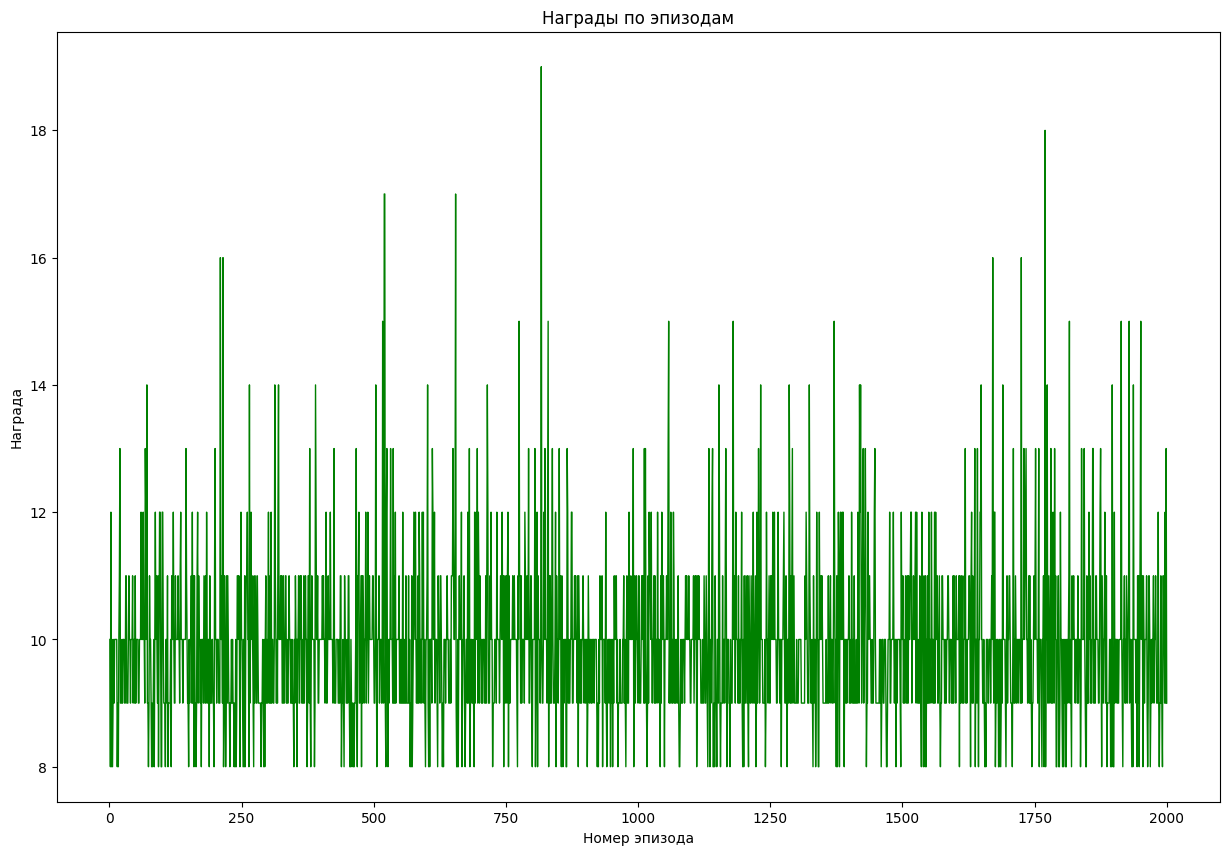

In [10]:
def main():
    # run_sarsa()
    # run_q_learning()
    run_double_q_learning()

if __name__ == '__main__':
    main()